In [19]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow_hub as hub
import os
import glob
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.utils import resample
from keras_preprocessing.image import ImageDataGenerator

IF_MOVE_FILE_NEEDED = False

In [20]:
# !rm -r images

In [21]:
all_images = glob.glob('../input/data/*/images/*.png')

In [22]:
data_dir = '../input/data'

In [23]:
def move_file(target_dir, df, all_image_paths):

    for img_path in tqdm(all_image_paths):
    
        filename = img_path.split('/')[-1]

        if filename in list(df['image_index']):

            new_img_path = os.path.join(target_dir, filename)

            shutil.copyfile(img_path, new_img_path)

In [24]:
parent_dir = '.'

img_directory = "images"
train_directory = 'train'
test_directory = 'test'

img_path = os.path.join(parent_dir, img_directory)

train_path = os.path.join(img_path, train_directory)
test_path = os.path.join(img_path, test_directory)

In [25]:
train_test_nih_dir = '../input/traintestnih1'

test_file = os.path.join(train_test_nih_dir, 'test_data.csv')
train_file = os.path.join(train_test_nih_dir, 'train_data.csv')

train_df = pd.read_csv(train_file, index_col=0)
test_df = pd.read_csv(test_file, index_col=0)

In [26]:
if IF_MOVE_FILE_NEEDED:
    
    mode = 0o666

    os.mkdir(img_path, mode)
    
    os.mkdir(train_path, mode)
    os.mkdir(test_path, mode)
    
    move_file(test_path, test_df, all_images)
    move_file(train_path, train_df, all_images)

In [27]:
train_df['pneumonia'] = train_df['pneumonia'].astype(str)
test_df['pneumonia'] = test_df['pneumonia'].astype(str)

di = {'0': "NORMAL", '1': "PNEUMONIA"}

train_df['pneumonia'].replace(di, inplace=True)
test_df['pneumonia'].replace(di, inplace=True)

In [28]:
batch_size = 64
image_size = (224, 224)


train_datagen = ImageDataGenerator(
    rescale=1./255.,  
    horizontal_flip = True, 
    vertical_flip = False, 
    height_shift_range= 0.1, 
    width_shift_range=0.1, 
    rotation_range=30,
    shear_range = 0.1,
    zoom_range=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255.)

In [29]:

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_path,
    x_col="image_index",
    y_col='pneumonia', 
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode='categorical',
    target_size=image_size,
    color_mode='rgb', 
    classes=['NORMAL', 'PNEUMONIA']
)

Found 2290 validated image filenames belonging to 2 classes.


In [30]:
valid_generator=test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_path,
    x_col="image_index",
    y_col='pneumonia',
    batch_size=batch_size,
    seed=42,
    shuffle=False,
    class_mode='categorical',
    target_size=image_size,
    color_mode='rgb', 
    classes=['NORMAL', 'PNEUMONIA']
)

Found 572 validated image filenames belonging to 2 classes.


In [31]:
num_classes = 2

URL = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

IMG_WIDTH, IMG_HEIGHT = image_size

feature_extractor = hub.KerasLayer(URL, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

feature_extractor.trainable = False

In [32]:
model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(2156, activation = 'relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1280, activation = 'relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(540, activation = 'relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation = 'softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              23564800  
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2156)              4417644   
_________________________________________________________________
dropout_5 (Dropout)          (None, 2156)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1280)              2760960   
_________________________________________________________________
dropout_6 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 540)              

In [33]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [34]:
EPOCHS = 100

model_file = os.path.join('model.h5')

early_stopping = tf.keras.callbacks.EarlyStopping(
                    monitor='val_loss', 
                    patience=5,
                    restore_best_weights=True
                 )

save_best = tf.keras.callbacks.ModelCheckpoint(
                model_file, 
                monitor='val_accuracy', 
                save_best_only=True
            )

history = model.fit(
    train_generator, 
    epochs = EPOCHS, 
    validation_data=valid_generator, 
    callbacks=[early_stopping, save_best]
)

Epoch 1/100
36/36 [==============================] - 77s 2s/step - loss: 1.0786 - accuracy: 0.5109 - val_loss: 0.6799 - val_accuracy: 0.5507
Epoch 2/100
36/36 [==============================] - 75s 2s/step - loss: 0.6885 - accuracy: 0.5738 - val_loss: 0.7010 - val_accuracy: 0.5787
Epoch 3/100
36/36 [==============================] - 74s 2s/step - loss: 0.6799 - accuracy: 0.5886 - val_loss: 0.6638 - val_accuracy: 0.6224
Epoch 4/100
36/36 [==============================] - 71s 2s/step - loss: 0.6668 - accuracy: 0.6079 - val_loss: 0.6786 - val_accuracy: 0.5909
Epoch 5/100
36/36 [==============================] - 71s 2s/step - loss: 0.6732 - accuracy: 0.5987 - val_loss: 0.6679 - val_accuracy: 0.6206
Epoch 6/100
36/36 [==============================] - 72s 2s/step - loss: 0.6657 - accuracy: 0.6109 - val_loss: 0.6559 - val_accuracy: 0.6346
Epoch 7/100
36/36 [==============================] - 71s 2s/step - loss: 0.6657 - accuracy: 0.6135 - val_loss: 0.6633 - val_accuracy: 0.6049
Epoch 8/100
3

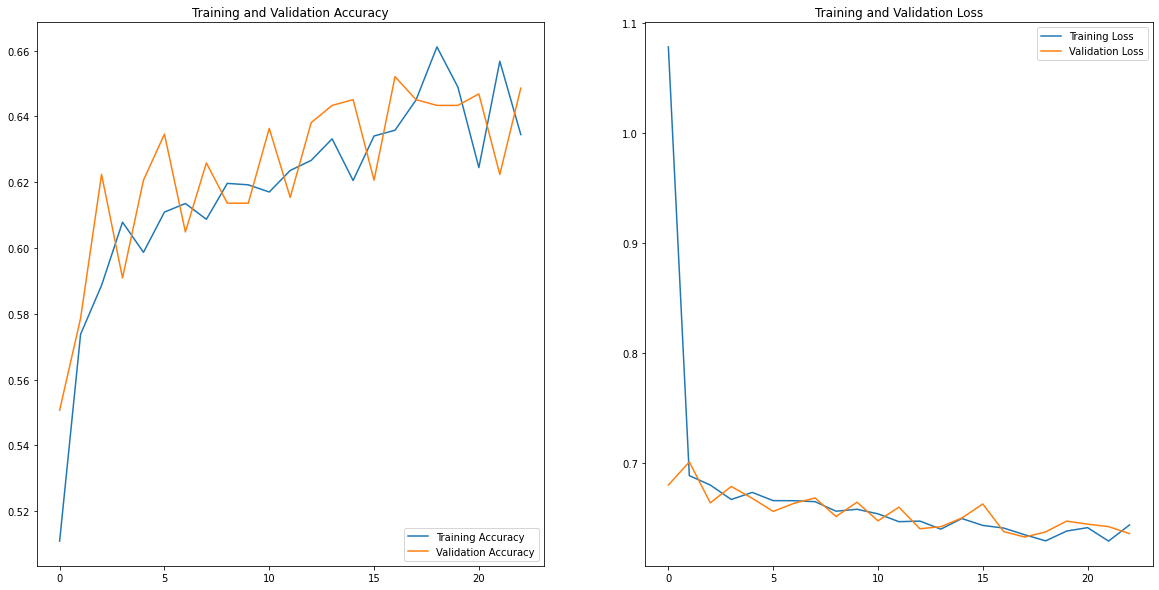

In [35]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(len(training_accuracy))

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()